# Question 2 - Prediction + Filtering
## Anwaar Hadi
This notebook contains solutions to Question 2 of the coding challenge. The notebook first depicts the process of building an Ordinary Least Squares (OLS) regression model to predict data values in a sine wave. Then, the process of filtering a noise corrupted sine wave using a Fast-Fourier Transform (FFT) spectra plot and bandpass filter is shown.

## Part i - OLS Regression Model

In [55]:
# import relevant libraries
import numpy as np
import pandas as pd
import csv
from scipy.signal import butter, sosfilt
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

In [56]:
# parse the csv files into arrays
xvals = None
clean_sine_vals = None
noisy_sine_vals = None
with open('../quant_spec_coding/data/xvalsSine.csv', 'r') as xfile, \
    open('../quant_spec_coding/data/cleanSine.csv', 'r') as clean_file, \
    open('../quant_spec_coding/data/noisySine.csv', 'r') as noisy_file:
    xvals = list(csv.reader(xfile))
    clean_sine_vals = list(csv.reader(clean_file))
    noisy_sine_vals = list(csv.reader(noisy_file))
xvals = np.array([x[0] for x in xvals], dtype=float)
clean_sine_vals = np.array([c[0] for c in clean_sine_vals], dtype=float)
noisy_sine_vals = np.array([n[0] for n in noisy_sine_vals], dtype=float)

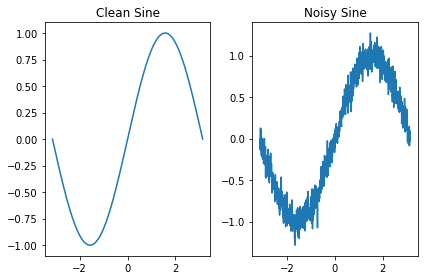

In [57]:
# Plot the clean and noisy sine functions
plt.subplot(1, 2, 1)
plt.plot(xvals, clean_sine_vals, label="Clean sin(x)")
plt.title("Clean Sine")
plt.subplot(1, 2, 2)
plt.plot(xvals, noisy_sine_vals, label="Noisy sin(x)")
plt.title("Noisy Sine")
plt.tight_layout()
plt.show()

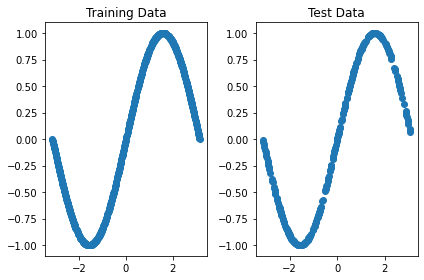

In [58]:
# perform 70/30(0.7/0.3) train/test split on data
X_train, X_test, y_train, y_test = train_test_split(xvals, clean_sine_vals, train_size=0.7)
plt.subplot(1, 2, 1)
plt.scatter(X_train, y_train)
plt.title("Training Data")
plt.subplot(1, 2, 2)
plt.scatter(X_test, y_test)
plt.title("Test Data")
plt.tight_layout()
plt.show()

In [59]:
# Generate polynomial features for the OLS regression. We will use a degree 5 polynomial basis
poly_feat = PolynomialFeatures(degree=5)
X_train_poly = poly_feat.fit_transform(X_train.reshape(-1, 1))
X_test_poly = poly_feat.fit_transform(X_test.reshape(-1, 1))

In [60]:
# Build the model using the generated polynomial features
model_ols = sm.OLS(y_train, X_train_poly).fit()
model_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.513e+06
Date:                Tue, 22 Aug 2023   Prob (F-statistic):               0.00
Time:                        22:28:48   Log-Likelihood:                 2804.5
No. Observations:                 700   AIC:                            -5597.
Df Residuals:                     694   BIC:                            -5570.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.000     -0.696      0.486      -0.001       0.000
x1             0.9874      0.000   2449.239      0.000       0.987       0.988
x2          9.211e-05      0.000      0.463      0.644      -0.000       0.000
x3            -0.1550      0.000   -980.057      0.000      -0.155      -0.155
x4         -1.107e-05   2.23e-05     -0.496      0.620   -5.49e-05    3.27e-05
x5             0.0056   1.39e-05    402.699      0.000       0.006       0.006
==============================================================================
Omnibus:                       20.953   Durbin-Watson:                   1.921
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               10.420
Skew:                           0.021   Prob(JB):                      0.00546
Kurtosis:                       2.404   Cond. No.                         251.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

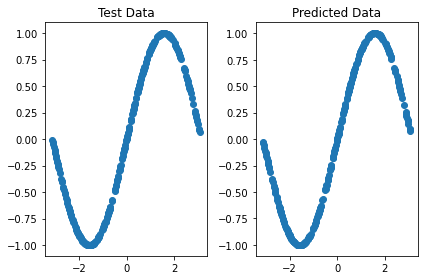

In [61]:
# Plot the predicted data and compare side by side with the test set
y_pred = model_ols.predict(X_test_poly)
plt.subplot(1, 2, 1)
plt.scatter(X_test, y_test)
plt.title("Test Data")
plt.subplot(1, 2, 2)
plt.scatter(X_test, y_pred)
plt.title("Predicted Data")
plt.tight_layout()
plt.show()

As can be seen above, the OLS model is a relatively accurate predictor of the test set, which is further evidenced by the high R-squared value for the model. Furthermore, it is worth noting that the even ordered coefficients for the model are very close to 0 and have less statistical signifcance (as evidenced by their high p-values). This is consistent from a mathematical perspective, as the OLS model is effectively a polynomial regression, and an ideal polynomial representation of sin(x) (i.e. the Taylor series expansion for the function) only has odd ordered terms.

## Part ii - Filtering Noise Corrupted Sine Wave

In order to filter the noise corrupted sine wave, we would need to know what frequencies of noise the waveform is corrupted by. We can find this by performing a Fast-Fourier Transform (FFT) on the data. This transform plots the Discrete Time Fourier Transform for the waveform. For a pure sine wave this is simply two impluses ("peaks"), one at $-f$ and one at $f$ where $f$ is the resonant (i.e. dominant or primary) frequency of the waveform. 

Thus, for the noise corrupted waveform, the process amounts to finding the "dominant" (i.e. largest peak) frequency (say $f_0$), then filtering out all other frequencies except for $f_0$, as these would be introducing noise into the waveform. This filtering can be achived using a bandpass filter, with a center frequency of $f_c=f_0$ and corner frequencies of $f_{c1}=f_0-(BW/2)$ and $f_{c2}=f_0+(BW/2)$ where $BW$ is the bandwidth of the filter.

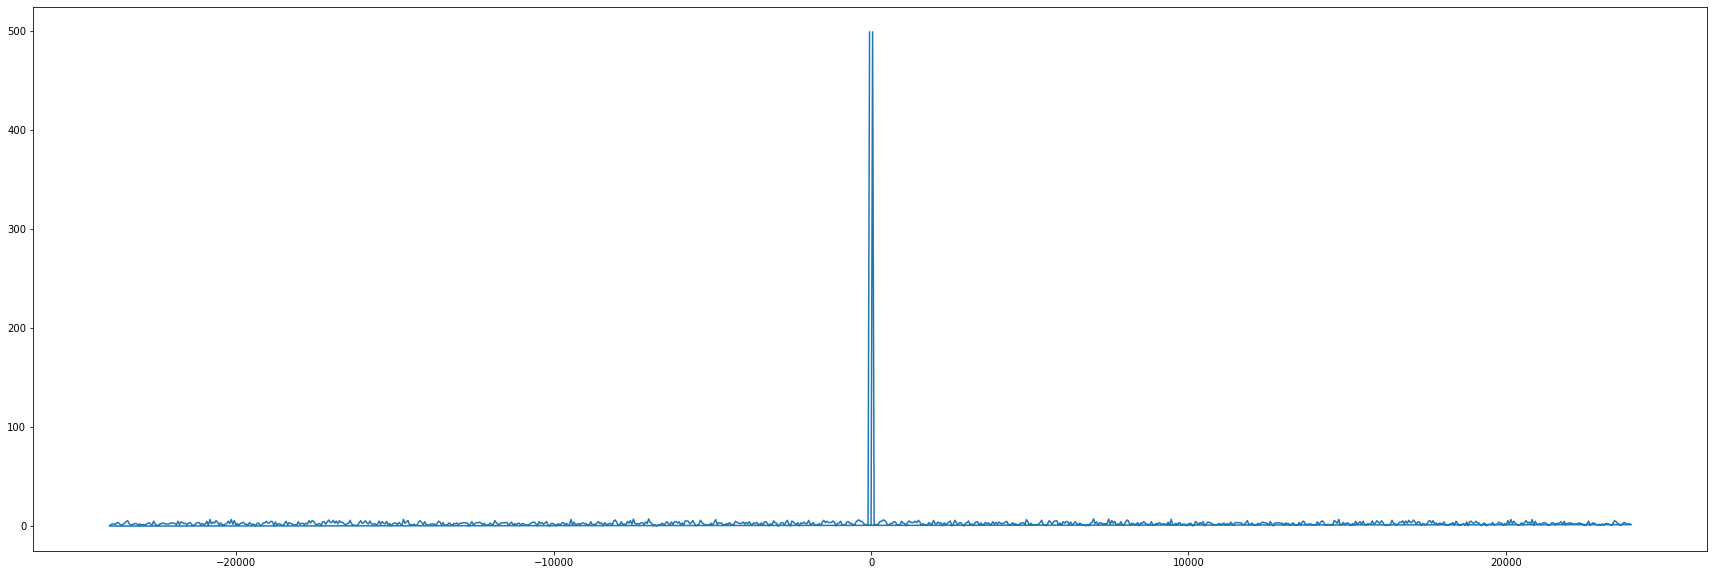

In [62]:
# Plot the Fast Fourier Transform (FFT) to find which frequencies of noise should be filtered out. 
N = len(xvals) # number of samples
SAMPLE_RATE = 48000 # sampling rate of 48kHz
fft_data = fft(noisy_sine_vals)
fft_xvals = fftfreq(N, 1/SAMPLE_RATE) # x-axis frequency values in Hz
plt.figure(figsize=(30,10))
plt.plot(fft_xvals, np.abs(fft_data))
plt.show()

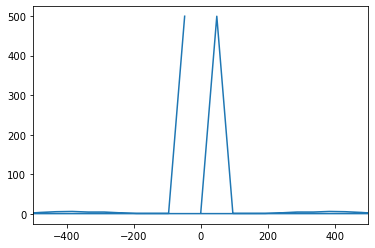

In [63]:
# zoom in on the middle of the plot to get the frequency of the sin wave
plt.xlim(-500, 500)
plt.plot(fft_xvals, np.abs(fft_data))
plt.show()

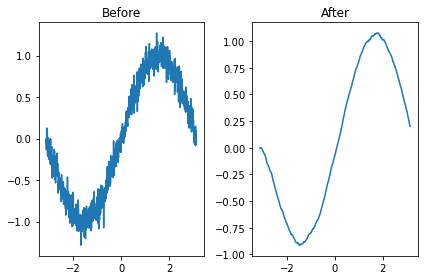

In [64]:
# From the The FFT above, the primary resonant frequency of the sine wave is ~100Hz. 
# To filter it, we can use a bandpass filter with a center
# frequency fo fc=100Hz and a bandwidth of 200Hz to account for delay. 
# The left and right corner frequencies are fc1=5Hz and fc2=195Hz respectively.
sos = butter(1, [5, 195], 'bandpass', fs=SAMPLE_RATE, output='sos')
filtered_sine = sosfilt(sos, noisy_sine_vals)
plt.subplot(1, 2, 1)
plt.plot(xvals, noisy_sine_vals)
plt.title("Before")
plt.subplot(1, 2, 2)
plt.plot(xvals, filtered_sine)
plt.title("After")
plt.tight_layout()
plt.show()

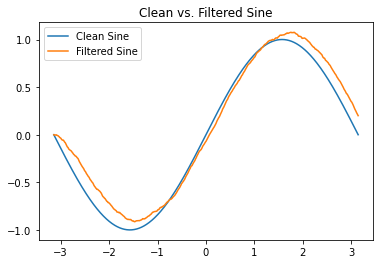

In [65]:
# plot the filtered waveform alongside the clean waveform
plt.plot(xvals, clean_sine_vals, label="Clean Sine")
plt.plot(xvals, filtered_sine, label="Filtered Sine")
plt.title("Clean vs. Filtered Sine")
plt.legend()
plt.show()

In [66]:
# compute residuals from filtered to clean sine
residuals = filtered_sine - clean_sine_vals
print("Residuals:\n", residuals)

Residuals:
 [-6.10578076e-04  5.04855057e-03  9.70229074e-03  1.41219698e-02
  2.17820014e-02  2.99029234e-02  3.49720195e-02  4.01764360e-02
  4.82338093e-02  5.51051778e-02  5.80682781e-02  6.17908791e-02
  6.69385013e-02  7.23962416e-02  7.83467726e-02  8.14807148e-02
  8.30527306e-02  8.71262467e-02  9.04994371e-02  9.14147945e-02
  9.53970044e-02  1.00585024e-01  1.04094918e-01  1.07375544e-01
  1.09601669e-01  1.10177636e-01  1.11358686e-01  1.15466178e-01
  1.19550660e-01  1.23911039e-01  1.30845214e-01  1.37151158e-01
  1.41164250e-01  1.42756605e-01  1.42836195e-01  1.43229265e-01
  1.45157390e-01  1.49567232e-01  1.50834104e-01  1.49834321e-01
  1.50756107e-01  1.49531546e-01  1.48098294e-01  1.47819560e-01
  1.47480490e-01  1.49256882e-01  1.53120102e-01  1.55099356e-01
  1.54103587e-01  1.53381823e-01  1.55948638e-01  1.59222953e-01
  1.62428318e-01  1.65653990e-01  1.69917766e-01  1.73765676e-01
  1.77402372e-01  1.81035489e-01  1.82921030e-01  1.85625415e-01
  1.85918240e

In [67]:
# Compute Root-Mean Squared Error (RMSE) from filtered to clean sine. This can also be normalized by the data
# range (which in this case is Pi/2-(-Pi/2) = Pi) to provide a percentage interpretation of the value
RMSE = mean_squared_error(clean_sine_vals, filtered_sine, squared=False)
RMSE_normalized = RMSE / np.pi
print("RMSE:", RMSE)
print("Normalized RMSE:", RMSE_normalized)

RMSE: 0.12298668032186279
Normalized RMSE: 0.03914787621537439


The Root-Mean Squared Error (RMSE) in this context measures the average difference between the filtered and clean sine wave values. In this case, this is ~0.123 or about a 3.9% error (as seen above).